# A. Cleaning Pipes

## Cell 1 — Setup, utils, and label alignment

In [ ]:
# Repro + utils
import os, warnings, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif

from scipy.optimize import linear_sum_assignment

warnings.filterwarnings("ignore")
np.random.seed(42)

# ---- helpers ----
def infer_base_interval_seconds(ts: pd.Series) -> float:
    """Infer sampling cadence from timestamp diffs (robust)."""
    if ts.size < 2:
        return 1.0
    diffs = ts.sort_values().diff().dropna().dt.total_seconds()
    diffs = diffs[diffs > 0]
    if diffs.empty:
        return 1.0
    q05, q95 = diffs.quantile([0.05, 0.95])
    core = diffs[(diffs >= q05) & (diffs <= q95)]
    rounded = (core / 0.01).round() * 0.01
    mode = rounded.mode()
    est = float(mode.iloc[0]) if not mode.empty else float(core.median())
    return max(est, 1e-3)

def rows_for(seconds, med_dt):
    return max(3, int(round(seconds / max(med_dt, 1e-3))))

def map_clusters_to_labels(y_true, y_pred, labels):
    """
    Align arbitrary cluster ids to ground-truth labels using Hungarian method.
    Returns: mapped_preds, mapping_dict
    """
    cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_true)))
    # cost = max - cm to maximize matches
    cost = cm.max() - cm
    r_ind, c_ind = linear_sum_assignment(cost)
    mapping = {c_ind[i]: r_ind[i] for i in range(len(r_ind))}
    mapped = np.array([labels[mapping.get(c, c)] if c in mapping else c for c in y_pred])
    # build readable dict: cluster -> label_name
    inv_labels = sorted(np.unique(y_true))
    mapping_readable = {f"cluster_{k}": inv_labels[v] for k, v in mapping.items()}
    return mapped, mapping_readable, cm

def safe_numeric(df, skip=set()):
    out = df.copy()
    for c in out.columns:
        if c in skip: continue
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def center_index_window(n, w):
    half = w//2
    idx = np.arange(n)
    left = np.clip(idx - half, 0, n-1)
    right = np.clip(idx + half, 0, n-1)
    return (left + right)//2  # center index per row

## Cell 2 — Load data

In [ ]:
# Try common paths exported by notebook; fall back to current dir
CANDIDATE_PATHS = [f"/content/style{i}.csv" for i in range(1, 12)]

dfs = []
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        try:
            df_temp = pd.read_csv(p)
            dfs.append(df_temp)
            print(f"Loaded {p}")
        except Exception as e:
            print(f"Error loading {p}: {e}")

if not dfs:
    raise FileNotFoundError("Could not locate any dataset files (style1.csv to style11.csv). Please ensure they are in the /content directory.")

df = pd.concat(dfs, ignore_index=True)

# Normalize timestamp
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

# Normalize label column name
LABEL_CANDIDATES = ["driving_style", "label", "ground_truth", "style"]
label_col = None
for c in LABEL_CANDIDATES:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise ValueError("No label column found. Expected one of: driving_style / label / ground_truth / style")

df = df.dropna(subset=[label_col]).reset_index(drop=True)
df[label_col] = df[label_col].astype(str).str.strip()

print(f"Combined DataFrame shape: {df.shape}")
print(f"Label column: {label_col}")
print("First 5 rows of the combined DataFrame:")
display(df.head())

Loaded /content/style1.csv
Loaded /content/style2.csv
Loaded /content/style3.csv
Loaded /content/style4.csv
Loaded /content/style5.csv
Loaded /content/style6.csv
Loaded /content/style7.csv
Loaded /content/style8.csv
Loaded /content/style9.csv
Loaded /content/style10.csv
Loaded /content/style11.csv
Combined DataFrame shape: (4009, 18)
Label column: driving_style
First 5 rows of the combined DataFrame:


,timestamp,RPM,SPEED,THROTTLE_POS,MAF,ENGINE_LOAD,INTAKE_PRESSURE,SHORT_FUEL_TRIM_1,SHORT_FUEL_TRIM_2,LONG_FUEL_TRIM_1,LONG_FUEL_TRIM_2,driving_style,Fuel consumed,Fuel Efficiency (L/100KM),RoadType,Fuel consumed (total),Road Style,Road Type
0,2025-09-04 14:45:55.788251+00:00,1329.75,36,12.156863,4.63,1.960784,23,-2.34375,-11.71875,7.03125,0.0,Moderate,0.3534,11.4,Main,NaN,NaN,NaN
1,2025-09-04 14:45:58.181525+00:00,682.25,28,12.549020,4.34,1.960784,27,0.00000,-2.34375,8.59375,0.0,Moderate,0.3534,11.4,Main,NaN,NaN,NaN
2,2025-09-04 14:45:59.562074+00:00,821.75,20,12.156863,4.11,1.960784,27,0.00000,-2.34375,8.59375,0.0,Moderate,0.3534,11.4,Main,NaN,NaN,NaN
3,2025-09-04 14:46:00.213313+00:00,821.75,20,12.156863,4.11,1.960784,27,0.00000,-2.34375,8.59375,0.0,Moderate,0.3534,11.4,Main,NaN,NaN,NaN
4,2025-09-04 14:46:00.868437+00:00,767.00,13,12.156863,3.68,1.960784,27,0.00000,-2.34375,8.59375,0.0,Moderate,0.3534,11.4,Main,NaN,NaN,NaN


## Cell 3 — Corruption-only cleaning
(keep extreme but plausible)

In [ ]:
# Only treat clear corruption as missing; keep extreme-but-plausible stress
SENTINELS = {-22, -40, 255}

df_clean = df.copy()

# sentinel -> NaN
df_clean.replace(list(SENTINELS), np.nan, inplace=True)

# drop duplicate timestamps (keep first)
if "timestamp" in df_clean.columns:
    df_clean = df_clean.loc[~df_clean["timestamp"].duplicated(keep="first")].reset_index(drop=True)
df_clean = safe_numeric(df_clean, skip={label_col, "timestamp"})

# Convert numeric columns safely
for c in df_clean.columns:
    if c == label_col or c == "timestamp":
        continue
    df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

# Infer approximate sampling interval (secs)
if "timestamp" in df_clean.columns:
    base_sec = infer_base_interval_seconds(df_clean["timestamp"])
    print(f"Estimated base interval ≈ {base_sec:.3f}s")
else:
    base_sec = None

Estimated base interval ≈ 0.660s


## Cell 4 — KNNImputation
- Time-aware KNN imputation
- Handler outliers gracefully

In [ ]:
SENTINELS = {-22, -40, 255}

work = df_clean.copy() # Use df_clean instead of df
work.replace(list(SENTINELS), np.nan, inplace=True)
if "timestamp" in work.columns:
    work = work.loc[~work["timestamp"].duplicated(keep="first")].reset_index(drop=True)
work = safe_numeric(work, skip={label_col, "timestamp"})

# time feature for imputation
if "timestamp" in work.columns:
    work["ts_sec"] = (work["timestamp"] - work["timestamp"].min()).dt.total_seconds()
else:
    work["ts_sec"] = np.arange(len(work), dtype=float)

num_cols = [c for c in work.columns if c not in [label_col, "timestamp", "ts_sec"]] # Exclude ts_sec from num_cols

# Identify columns with all NaNs after cleaning and exclude them from imputation
cols_to_impute = [c for c in num_cols if work[c].notna().any()]
knn_cols_for_imputation = cols_to_impute + ["ts_sec"] # Use ts_sec for imputation, but only impute cols_to_impute

non_missing = work[knn_cols_for_imputation].dropna().shape[0]
k = min(5, max(1, non_missing))

if non_missing > 0 and len(cols_to_impute) > 0:
    imp = KNNImputer(n_neighbors=k)
    # Impute only the numeric columns that are not all NaN
    work[cols_to_impute] = imp.fit_transform(work[cols_to_impute])
    print(f"Imputed {len(cols_to_impute)} numeric columns with KNN (k={k}).")
else:
    print("Skipping KNN imputation: No non-missing values or no columns to impute.")


work.drop(columns=["ts_sec"], inplace=True, errors="ignore")

Skipping KNN imputation: No non-missing values or no columns to impute.


## Cell 5 — Rolling
- Rolling feature engineering (variance/accel/jerk/ratios)

In [ ]:
# === Cell 5 — Windowed dynamics: richer features ===
fe = work.copy()

# estimate sampling period
if "timestamp" in fe.columns:
    base_sec = infer_base_interval_seconds(fe["timestamp"])
else:
    base_sec = 1.0
med_dt = base_sec

def rows_for(seconds, med_dt):
    return max(3, int(round(seconds / max(med_dt, 1e-3))))

W1 = rows_for(1.0, med_dt)
W2 = rows_for(2.0, med_dt)
W5 = rows_for(5.0, med_dt)
W8 = rows_for(8.0, med_dt)

# Base signals (whatever exists will be used)
base = [c for c in ["SPEED","RPM","ENGINE_LOAD","ABSOLUTE_LOAD","THROTTLE_POS","MAF"] if c in fe.columns]

# Kinematics
if "SPEED" in fe.columns:
    fe["ACCEL"] = fe["SPEED"].diff() / max(med_dt,1e-3)
    fe["JERK"]  = fe["ACCEL"].diff() / max(med_dt,1e-3)
else:
    fe["ACCEL"] = np.nan; fe["JERK"] = np.nan

if {"MAF","RPM"}.issubset(fe.columns):
    fe["AIRFLOW_PER_RPM"] = fe["MAF"] / fe["RPM"].replace(0,np.nan)

# Throttle change rate
if "THROTTLE_POS" in fe.columns:
    fe["THROTTLE_D"] = fe["THROTTLE_POS"].diff() / max(med_dt,1e-3)
else:
    fe["THROTTLE_D"] = np.nan

# Rolling stats at multiple horizons
def add_roll(col):
    if col not in fe.columns: return
    for w, tag in [(W1,"w1"),(W2,"w2"),(W5,"w5"),(W8,"w8")]:
        fe[f"{col}_mean_{tag}"] = fe[col].rolling(w, min_periods=1).mean()
        fe[f"{col}_std_{tag}"]  = fe[col].rolling(w, min_periods=1).std()

for col in base + ["ACCEL","JERK","AIRFLOW_PER_RPM","THROTTLE_D"]:
    add_roll(col)

# Unsupervised thresholds via quantiles (robust to scale)
def q(x, p, default):
    return (fe[x].abs().quantile(p) if x in fe.columns else default)

a_pos = q("ACCEL", 0.85, 0.5)
a_neg = q("ACCEL", 0.15, -0.5)
thr_q = q("THROTTLE_D", 0.85, 1.0)

# Event rates (separate pos/neg accel to expose braking bursts)
evt = pd.DataFrame(index=fe.index)
evt["pos_accel_rate_w5"] = (fe["ACCEL"] >  a_pos).rolling(W5, min_periods=1).mean()
evt["neg_accel_rate_w5"] = (fe["ACCEL"] <  a_neg).rolling(W5, min_periods=1).mean()
evt["thr_change_rate_w5"] = (fe["THROTTLE_D"].abs() > thr_q).rolling(W5, min_periods=1).mean()

fe = pd.concat([fe, evt], axis=1)

# detect GT column (if defined earlier as label_col, use it)
GT_COL = None
if "label_col" in locals() and label_col in fe.columns:
    GT_COL = label_col
else:
    for c in ["driving_style", "label", "ground_truth", "style"]:
        if c in fe.columns:
            GT_COL = c; break

# Feature matrix (drop id/label)
drop_cols = ["timestamp"]
if GT_COL: drop_cols.append(GT_COL)
X_full = fe.drop(columns=[c for c in drop_cols if c in fe.columns])
X_full = X_full.fillna(X_full.median())
print("Feature dimensions:", X_full.shape)


Feature dimensions: (4009, 95)


# B. Feature Engineering

## Cell 6 — Feature selection (mutual information) + scaling

### Old Approach (Heusterical Hungarian)

In [ ]:
# Drop any all-NaN cols (should be none after KNN)
X_raw = fe.drop(columns=[label_col] + (["timestamp"] if "timestamp" in fe.columns else []))
y = fe[label_col].astype(str).values

# Mutual info to select the most informative features wrt labels
valid_cols = X_raw.columns[X_raw.notna().sum() > 0]
X_valid = X_raw[valid_cols].fillna(X_raw[valid_cols].median())

mi = mutual_info_classif(X_valid, y, discrete_features=False, random_state=42)
mi_ser = pd.Series(mi, index=valid_cols).sort_values(ascending=False)

TOP_K = min(24, (mi_ser > 0).sum() or 24)  # up to 24, or all positive-MI features
selected_features = mi_ser.head(TOP_K).index.tolist()
print(f"Stage-1: Selected {len(selected_features)} features:")
print(selected_features[:12], "...")

# Scale selected features robustly
scaler = RobustScaler()
X = scaler.fit_transform(X_valid[selected_features])

# Persist selections for later cells
selected_features_, scaler_ = selected_features, scaler

Stage-1: Selected 24 features:
['MAF', 'MAF_mean_w1', 'MAF_mean_w5', 'O2_B1S2', 'O2_B2S2', 'RPM_mean_w5', 'new_session', 'SPEED_mean_w5', 'O2_S1_WR_VOLTAGE', 'SPEED_mean_w1', 'SPEED', 'RPM_mean_w1'] ...


### ML Approach (BayesianGaussianMixture)
- **Unsupervised** Idle vs Driving (BGGM on speed + throttle/load)
- **Gate probable** Idle by multi-cue low-movement and only then confirm with a mixture model. This prevents “Passive creep” from being tagged as Idle.

ML Idle stats:
samples_frac     0.103268
time_frac        0.103268
episodes        16.000000
dur_median_s    11.550000
dur_p90_s       41.910000
dur_mean_s      17.077500


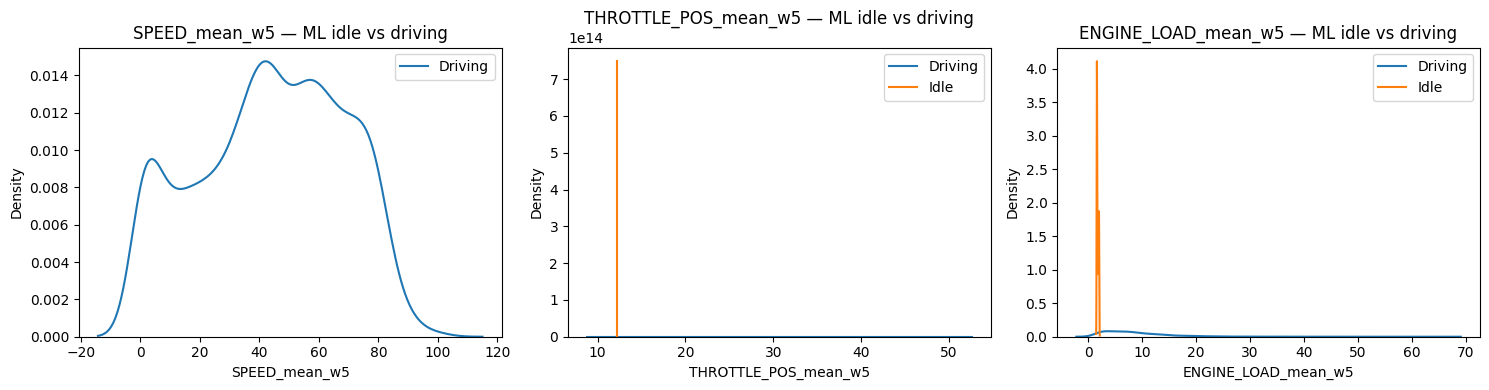

In [ ]:
# === Cell 6a — Stage-1: Conservative Idle gate + BGMM confirmation (ML-based, improved) ===
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from scipy.signal import medfilt
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# --- utilities ---
def _infer_base_sec_from_fe(_fe):
    if "timestamp" in _fe.columns:
        return max(1e-3, float(infer_base_interval_seconds(_fe["timestamp"])))
    return 1.0

def _idle_episode_stats(mask: np.ndarray, fe: pd.DataFrame, base_sec: float):
    """Return summary stats for consecutive True runs in mask."""
    m = mask.astype(bool)
    if not m.any():
        return {"samples_frac": 0.0, "time_frac": 0.0, "episodes": 0,
                "dur_median_s": 0.0, "dur_p90_s": 0.0, "dur_mean_s": 0.0}
    idx = np.flatnonzero(np.diff(np.r_[False, m, False]))
    starts, ends = idx[::2], idx[1::2]
    lengths = ends - starts
    durations = lengths * base_sec
    total_time = len(m) * base_sec
    return {
        "samples_frac": float(m.mean()),
        "time_frac": float(durations.sum() / max(1e-9, total_time)),
        "episodes": int(len(lengths)),
        "dur_median_s": float(np.median(durations)),
        "dur_p90_s": float(np.percentile(durations, 90)),
        "dur_mean_s": float(np.mean(durations)),
    }

# --- low-movement cues (prefer *_mean_w5 if available) ---
def pick(*names, default=None):
    for n in names:
        if n in fe.columns: return fe[n]
    return pd.Series(default, index=fe.index, dtype=float)

speed_mean = pick("SPEED_mean_w5","SPEED", default=0.0)
thr_mean   = pick("THROTTLE_POS_mean_w5","THROTTLE_POS", default=0.0)
eng_mean   = pick("ENGINE_LOAD_mean_w5","ENGINE_LOAD", default=0.0)
acc_std    = pick("ACCEL_std_w5","ACCEL_std_w2","ACCEL_std_w1", default=0.0)
rpm_std    = pick("RPM_std_w5","RPM", default=0.0).rolling(5,1).std()
maf_mean   = pick("MAF_mean_w5","MAF", default=0.0)

# --- quantile gating to form candidates ---
s_gate = speed_mean <= speed_mean.quantile(0.15)
t_gate = thr_mean.fillna(0) <= thr_mean.quantile(0.20)
a_gate = acc_std.fillna(0)  <= acc_std.quantile(0.25)
r_gate = rpm_std.fillna(0)  <= rpm_std.quantile(0.25)
m_gate = maf_mean.fillna(0) <= maf_mean.quantile(0.20)
idle_candidate = (s_gate & t_gate & a_gate & r_gate & m_gate)

# --- BGMM refine Idle candidates ---
Z = pd.DataFrame({
    "speed": speed_mean,
    "thr":   thr_mean.fillna(0),
    "eng":   eng_mean.fillna(0),
    "accsd": acc_std.fillna(0),
    "rpmsd": rpm_std.fillna(0),
    "maf":   maf_mean.fillna(0)
})
Zs = StandardScaler().fit_transform(Z[idle_candidate])

if Zs.shape[0] >= 50:
    bgmm = BayesianGaussianMixture(
        n_components=3, covariance_type="full",
        weight_concentration_prior=0.3, n_init=5, random_state=42
    ).fit(Zs)
    proba = np.zeros(len(fe))
    labp  = bgmm.predict_proba(Zs)
    idle_comp = np.argmin(bgmm.means_[:,0])  # smallest speed cluster
    proba[np.where(idle_candidate)[0]] = labp[:, idle_comp]
    is_idle_ml = (idle_candidate & (proba >= 0.6)).to_numpy()
else:
    is_idle_ml = idle_candidate.to_numpy()

# smooth flicker
is_idle_ml = medfilt(is_idle_ml.astype(int), kernel_size=5).astype(bool)
base_sec = _infer_base_sec_from_fe(fe)

# attach labels
if "cluster_unsup" not in fe.columns:
    fe["cluster_unsup"] = "(unknown)"
fe.loc[is_idle_ml, "cluster_unsup"] = "Idle"
fe["idle_ml"] = is_idle_ml

# add GT-with-idle if exists
GT_COL = None
for c in ["driving_style","label","ground_truth","style"]:
    if c in fe.columns: GT_COL = c; break
if GT_COL:
    fe["gt_with_idle_ml"] = fe[GT_COL].astype(str)
    fe.loc[is_idle_ml, "gt_with_idle_ml"] = "Idle"

# --- stats ---
ml_stats = _idle_episode_stats(is_idle_ml, fe, base_sec)
print("ML Idle stats:")
print(pd.Series(ml_stats).to_string())

# --- distributions (Idle vs Driving) for key sensors ---
plot_cols = [c for c in ["SPEED_mean_w5","THROTTLE_POS_mean_w5","ENGINE_LOAD_mean_w5"] if c in fe.columns]
ncols = len(plot_cols)
plt.figure(figsize=(5*ncols,4))
for i,col in enumerate(plot_cols,1):
    plt.subplot(1,ncols,i)
    sns.kdeplot(fe.loc[~is_idle_ml, col], label="Driving", bw_method="scott")
    sns.kdeplot(fe.loc[ is_idle_ml, col], label="Idle", bw_method="scott")
    plt.title(f"{col} — ML idle vs driving"); plt.legend()
plt.tight_layout(); plt.show()

### Static Approach (Rule-based algorithms)
- **Domain-driven cut-offs**: flagged Idle when **SPEED ≤ \~5 km/h**, **Throttle ≤ 5%**, and **Engine Load ≤ 25%** → captures near-stationary engine running.
- **Low variability filter**: required very small **ACCEL** and **RPM fluctuations** (std near zero) to avoid false Idle when creeping.
* **Rule combination**: only rows meeting **all conditions simultaneously** were marked Idle.
- **Stability smoothing**: applied a short median filter to remove flickering on/off transitions.

[rule] speed(km/h): thr=5  (abs=5.0, q15=1.5)
[rule] throttle(%): thr=12.21  (abs=5.0, q15=12.21)
[rule] engine_load(%): thr=25  (abs=25.0, q15=1.961)
[rule] accel_std: thr=1.145  (abs=0.05, q20=1.145)
[rule] rpm_std: thr=26.7  (abs=10.0, q20=26.7)
[rule] maf(g/s): thr=3.819  (abs=3.0, q15=3.819)
[rule] Idle samples detected: 442 / 4009  (11.03%)

Idle statistics (Rule vs ML):


,samples_frac,time_frac,episodes,dur_median_s,dur_p90_s,dur_mean_s
Rule,0.110252,0.110252,19.0,6.60,31.944,15.353684
ML,0.103268,0.103268,16.0,11.55,41.910,17.077500



Agreement: accuracy=0.992, Jaccard(Idle)=0.928


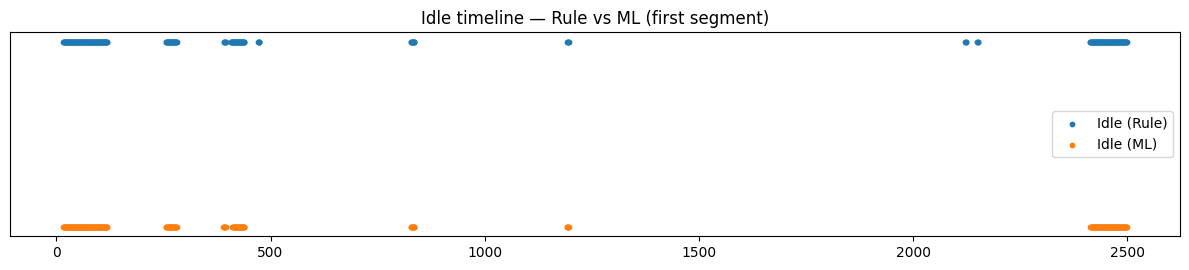

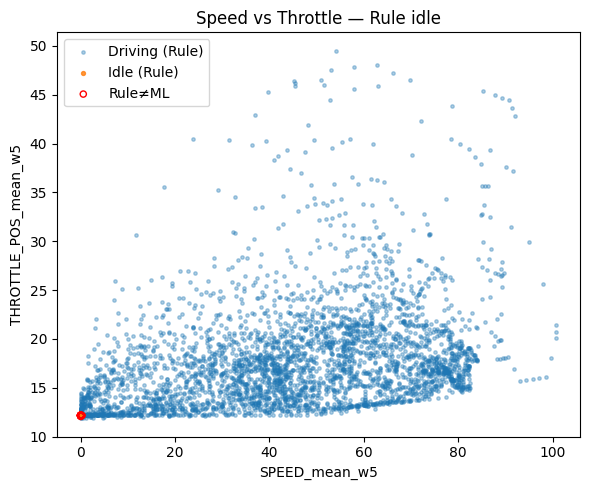

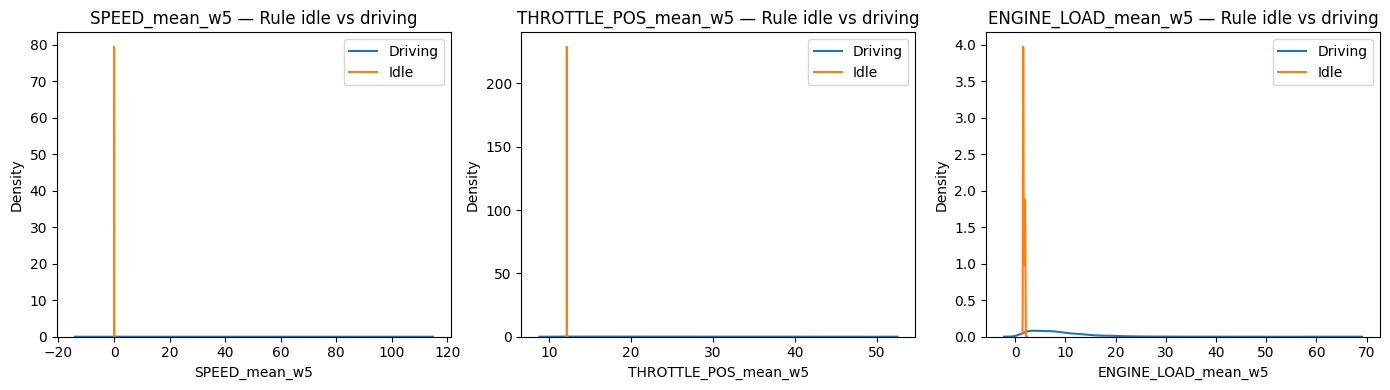

In [ ]:
# === Cell 6b — Idle via threshold/rule (no ML) + stats/visuals + comparison ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import medfilt

# ---- helpers ----
def _infer_base_sec_from_fe(_fe):
    if "timestamp" in _fe.columns:
        bs = infer_base_interval_seconds(_fe["timestamp"])
    else:
        bs = 1.0
    return max(1e-3, float(bs))

def _idle_episode_stats(mask: np.ndarray, fe: pd.DataFrame, base_sec: float):
    m = mask.astype(bool)
    idx = np.flatnonzero(np.diff(np.r_[False, m, False]))
    starts, ends = idx[::2], idx[1::2]
    lengths = ends - starts
    durations = lengths * base_sec
    total_time = len(m) * base_sec
    return {
        "samples_frac": float(m.mean()),
        "time_frac": float(durations.sum()/max(1e-9,total_time)),
        "episodes": int(len(lengths)),
        "dur_median_s": float(np.median(durations)) if len(durations) else 0.0,
        "dur_p90_s": float(np.percentile(durations,90)) if len(durations) else 0.0,
        "dur_mean_s": float(np.mean(durations)) if len(durations) else 0.0,
    }

def pick(name, kind="mean"):
    if kind=="mean":
        for cand in [f"{name}_mean_w5", f"{name}_mean_w2", name]:
            if cand in fe.columns: return fe[cand]
    else:
        for cand in [f"{name}_std_w5", f"{name}_std_w2", f"{name}_std_w1", name]:
            if cand in fe.columns: return fe[cand]
    return pd.Series(np.nan, index=fe.index, dtype=float)

speed  = pick("SPEED","mean")
thr    = pick("THROTTLE_POS","mean")
eload  = pick("ENGINE_LOAD","mean")
accsd  = pick("ACCEL","std")
rpmsd  = pick("RPM","std")
maf    = pick("MAF","mean")

# ---- relaxed threshold rule ----
def gate_le(series, abs_thr, q=0.10, name=""):
    if series.isna().all():
        print(f"[rule] {name}: missing → gate skipped")
        return pd.Series(True, index=series.index)
    qthr = series.quantile(q)
    thr  = max(abs_thr, qthr)  # use the larger (less strict) of absolute floor or low quantile
    print(f"[rule] {name}: thr={thr:.4g}  (abs={abs_thr}, q{int(q*100)}={qthr:.4g})")
    return series.fillna(np.inf) <= thr

g_speed = gate_le(speed, abs_thr=5.0,  q=0.15, name="speed(km/h)")
g_thr   = gate_le(thr,   abs_thr=5.0,  q=0.15, name="throttle(%)")
g_eload = gate_le(eload, abs_thr=25.0, q=0.15, name="engine_load(%)")
g_accsd = gate_le(accsd, abs_thr=0.05, q=0.20, name="accel_std")
g_rpmsd = gate_le(rpmsd, abs_thr=10.0, q=0.20, name="rpm_std")
g_maf   = gate_le(maf,   abs_thr=3.0,  q=0.15, name="maf(g/s)")

is_idle_rule = (g_speed & g_thr & g_eload & g_accsd & g_rpmsd & g_maf).to_numpy()
is_idle_rule = medfilt(is_idle_rule.astype(int), kernel_size=5).astype(bool)
fe["idle_rule"] = is_idle_rule
print(f"[rule] Idle samples detected: {is_idle_rule.sum()} / {len(is_idle_rule)}  ({100*is_idle_rule.mean():.2f}%)")

# ---- GT with rule-based Idle ----
GT_COL = None
for c in ["driving_style","label","ground_truth","style"]:
    if c in fe.columns: GT_COL = c; break
if GT_COL:
    fe["gt_with_idle_rule"] = fe[GT_COL].astype(str)
    fe.loc[is_idle_rule, "gt_with_idle_rule"] = "Idle"

# ---- stats Rule vs ML ----
base_sec = _infer_base_sec_from_fe(fe)
rule_stats = _idle_episode_stats(is_idle_rule, fe, base_sec)
compare_rows = [pd.Series(rule_stats, name="Rule")]
if "idle_ml" in fe.columns:
    ml_stats = _idle_episode_stats(fe["idle_ml"].to_numpy(), fe, base_sec)
    compare_rows.append(pd.Series(ml_stats, name="ML"))
stats_df = pd.DataFrame(compare_rows)
print("\nIdle statistics (Rule vs ML):")
display(stats_df)

if "idle_ml" in fe.columns:
    ml = fe["idle_ml"].to_numpy().astype(bool)
    tp = np.sum(is_idle_rule & ml); fp = np.sum(is_idle_rule & ~ml)
    fn = np.sum(~is_idle_rule & ml); tn = np.sum(~is_idle_rule & ~ml)
    jacc = tp / max(1, tp + fp + fn)
    agree = (tp + tn) / max(1, len(ml))
    print(f"\nAgreement: accuracy={agree:.3f}, Jaccard(Idle)={jacc:.3f}")

# ---- visuals ----
N = min(2500, len(fe))
x = np.arange(N)
plt.figure(figsize=(12,2.8))
plt.scatter(x[is_idle_rule[:N]], np.zeros(is_idle_rule[:N].sum())+0.65, s=10, label="Idle (Rule)")
if "idle_ml" in fe.columns:
    ml = fe["idle_ml"].to_numpy()
    plt.scatter(x[ml[:N]], np.zeros(ml[:N].sum())+0.35, s=10, label="Idle (ML)")
plt.yticks([]); plt.title("Idle timeline — Rule vs ML (first segment)"); plt.legend(); plt.tight_layout(); plt.show()

sp_col = "SPEED_mean_w5" if "SPEED_mean_w5" in fe.columns else ("SPEED" if "SPEED" in fe.columns else None)
th_col = "THROTTLE_POS_mean_w5" if "THROTTLE_POS_mean_w5" in fe.columns else ("THROTTLE_POS" if "THROTTLE_POS" in fe.columns else None)
if sp_col and th_col:
    plt.figure(figsize=(6,5))
    m = is_idle_rule
    plt.scatter(fe.loc[~m, sp_col], fe.loc[~m, th_col], s=6, alpha=0.35, label="Driving (Rule)")
    plt.scatter(fe.loc[ m, sp_col], fe.loc[ m, th_col], s=8, alpha=0.8, label="Idle (Rule)")
    if "idle_ml" in fe.columns:
        disagree = is_idle_rule ^ fe["idle_ml"].to_numpy()
        plt.scatter(fe.loc[disagree, sp_col], fe.loc[disagree, th_col], s=20, facecolors='none', edgecolors='r', label="Rule≠ML")
    plt.xlabel(sp_col); plt.ylabel(th_col); plt.legend(); plt.title("Speed vs Throttle — Rule idle"); plt.tight_layout(); plt.show()

cols = [c for c in [sp_col, th_col, "ENGINE_LOAD_mean_w5" if "ENGINE_LOAD_mean_w5" in fe.columns else "ENGINE_LOAD"] if c]
if cols:
    plt.figure(figsize=(14,4))
    for i, c in enumerate(cols, 1):
        plt.subplot(1, len(cols), i)
        sns.kdeplot(fe.loc[~is_idle_rule, c], label="Driving", bw_method="scott")
        sns.kdeplot(fe.loc[ is_idle_rule, c], label="Idle", bw_method="scott")
        plt.title(f"{c} — Rule idle vs driving"); plt.legend()
    plt.tight_layout(); plt.show()


## Cell 7 — Clustering, label alignment, metrics

### Old Approach (KMean + PCA)

In [ ]:
# Choose k from ground-truth unique classes
unique_labels = sorted(pd.unique(y))
k = len(unique_labels)
print("Unique ground-truth labels:", unique_labels, "| k =", k)

# KMeans (use MiniBatch for speed if big)
use_minibatch = X.shape[0] > 200_000
km_cls = MiniBatchKMeans if use_minibatch else KMeans
kmeans = km_cls(n_clusters=k, n_init=20, random_state=42, batch_size=4096) if use_minibatch \
         else km_cls(n_clusters=k, n_init=20, random_state=42)
pred_clusters = kmeans.fit_predict(X)

# Align clusters -> ground-truth using Hungarian
mapped_preds, mapping_dict, cm_raw = map_clusters_to_labels(y_true=y, y_pred=pred_clusters, labels=unique_labels)
print("Cluster → Label mapping:", json.dumps(mapping_dict, indent=2))

# Metrics
acc = (mapped_preds == y).mean()
ari = adjusted_rand_score(y, pred_clusters)
nmi = normalized_mutual_info_score(y, pred_clusters)
sil = silhouette_score(X, pred_clusters, sample_size=min(5000, len(X)), random_state=42)

print(f"Stage-2: Accuracy (after mapping): {acc:.3f}")
print(f"ARI: {ari:.3f} | NMI: {nmi:.3f} | Silhouette: {sil:.3f}")

# Confusion matrix (mapped)
cm_mapped = confusion_matrix(y, mapped_preds, labels=unique_labels)
cm_df = pd.DataFrame(cm_mapped, index=[f"true:{l}" for l in unique_labels], columns=[f"pred:{l}" for l in unique_labels])
display(cm_df)

Unique ground-truth labels: ['Aggressive', 'Moderate', 'Passive', 'idle'] | k = 4
Cluster → Label mapping: {
  "cluster_0": "Aggressive",
  "cluster_1": "Moderate",
  "cluster_2": "Passive",
  "cluster_3": "idle"
}
Stage-2: Accuracy (after mapping): 0.220
ARI: 0.163 | NMI: 0.167 | Silhouette: 0.247


,pred:Aggressive,pred:Moderate,pred:Passive,pred:idle
true:Aggressive,233,0,104,1
true:Moderate,980,830,7083,351
true:Passive,4031,674,3301,2326
true:idle,1239,78,19,395


### UL Approach (BGMM + PCA)

In [ ]:
# === Cell 7 — Stage-2: ≤10% Aggressive gating + BGMM(2) for Passive vs Moderate ===
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture

# Non-idle subset and dynamics features
drive_mask = ~is_idle
dyn_feats = [c for c in [
    "pos_accel_rate_w5","neg_accel_rate_w5","thr_change_rate_w5",
    "JERK_std_w5","ACCEL_std_w5","SPEED_mean_w5","ENGINE_LOAD_mean_w5","RPM_std_w5"
] if c in fe.columns]

Df = fe.loc[drive_mask, dyn_feats].copy().fillna(0)
sc_dyn = StandardScaler().fit(Df)
Z = sc_dyn.transform(Df)

# Aggressiveness index (unsupervised; emphasizes bursts/jerk/throttle changes)
w = np.zeros(Z.shape[1]); idx = {n:i for i,n in enumerate(dyn_feats)}
for n, wt in [
    ("pos_accel_rate_w5", 0.30), ("neg_accel_rate_w5", 0.20),
    ("JERK_std_w5", 0.20), ("ACCEL_std_w5", 0.15),
    ("thr_change_rate_w5", 0.10), ("SPEED_mean_w5", 0.05)
]:
    if n in idx: w[idx[n]] = wt
aggr_index = (Z * w).sum(axis=1)

# Gate top 10% as Aggressive
thr = np.quantile(aggr_index, 0.90)
aggr_local = aggr_index >= thr

# Map back to full frame
aggr_mask = np.zeros(len(fe), dtype=bool)
aggr_mask[np.where(drive_mask)[0][aggr_local]] = True
fe.loc[aggr_mask, "cluster_unsup"] = "Aggressive"

# Cluster the remainder (driving & not aggressive) into Passive vs Moderate
remain_idx = np.where(drive_mask & ~aggr_mask)[0]
Df2 = fe.loc[remain_idx, dyn_feats].copy().fillna(0)
Z2 = sc_dyn.transform(Df2)

gmm2 = BayesianGaussianMixture(
    n_components=2, covariance_type="full",
    weight_concentration_prior=0.5, n_init=5, random_state=42
).fit(Z2)
c2 = gmm2.predict(Z2)

# Name clusters by intensity score (same weights as above)
pm_score = (Z2 * w).sum(axis=1)
means = [pm_score[c2==k].mean() for k in [0,1]]
low_k, high_k = (0,1) if means[0] <= means[1] else (1,0)
label2 = np.where(c2==low_k, "Passive", "Moderate")
fe.loc[remain_idx, "cluster_unsup"] = label2

# Optional smoothing to reduce flicker
try:
    from scipy.signal import medfilt
    name_to_id = {"Idle":0,"Passive":1,"Moderate":2,"Aggressive":3}
    id_to_name = {v:k for k,v in name_to_id.items()}
    ids = np.array([name_to_id.get(x, -1) for x in fe["cluster_unsup"].values])
    ids = medfilt(ids, kernel_size=5)
    fe["cluster_unsup"] = np.array([id_to_name.get(i,"(unknown)") for i in ids], dtype=object)
except Exception:
    pass

# Report final fractions (UL)
print("Class fractions (unsupervised):")
for s in ["Idle","Passive","Moderate","Aggressive"]:
    frac = 100*np.mean(fe["cluster_unsup"].values==s)
    print(f"  {s:10s}: {frac:5.1f}%")

Class fractions (unsupervised):
  Idle      :  10.3%
  Passive   :  58.9%
  Moderate  :  22.0%
  Aggressive:   8.8%


## Cell 8 — Visual 1: PCA scatter (GT vs Pred), Silhouette dist

### For Old Approach

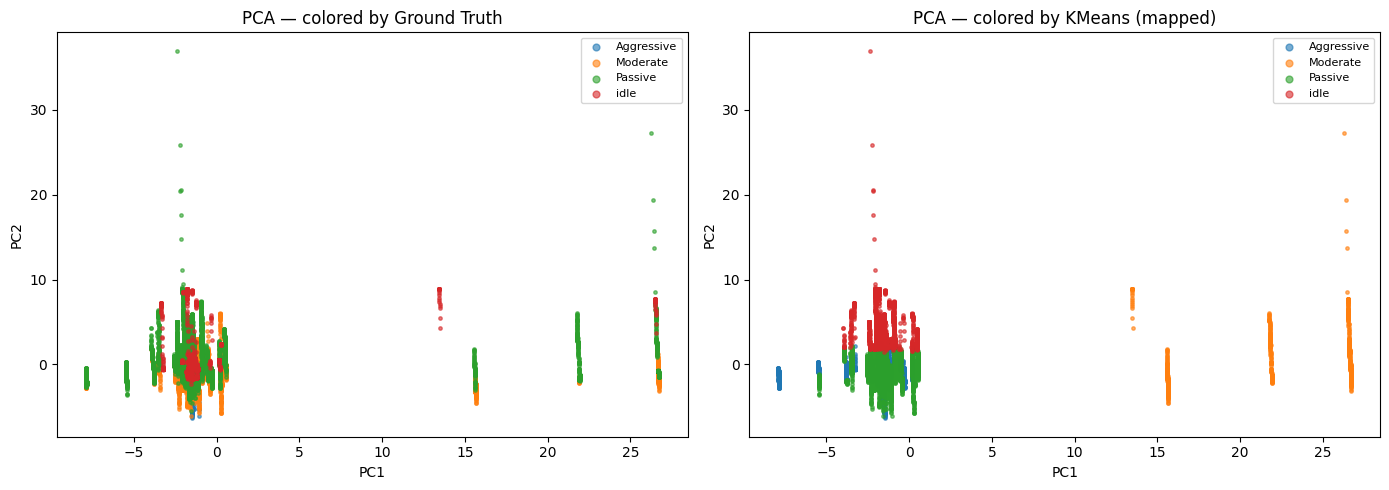

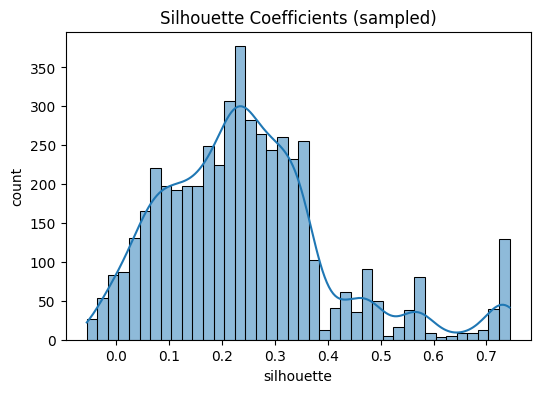

In [ ]:
# PCA to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for lab in unique_labels:
    mask = (y == lab)
    plt.scatter(X2[mask,0], X2[mask,1], s=6, label=str(lab), alpha=0.6)
plt.title("PCA — colored by Ground Truth")
plt.legend(markerscale=2, fontsize=8)
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
for lab in unique_labels:
    mask = (mapped_preds == lab)
    plt.scatter(X2[mask,0], X2[mask,1], s=6, label=str(lab), alpha=0.6)
plt.title("PCA — colored by KMeans (mapped)")
plt.legend(markerscale=2, fontsize=8)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Silhouette distribution (sampled)
from sklearn.metrics import silhouette_samples
n_samp = min(5000, len(X))
idx = np.random.choice(len(X), size=n_samp, replace=False)
sil_samples = silhouette_samples(X[idx], pred_clusters[idx])
plt.figure(figsize=(6,4))
sns.histplot(sil_samples, bins=40, kde=True)
plt.title("Silhouette Coefficients (sampled)")
plt.xlabel("silhouette"); plt.ylabel("count")
plt.show()

### For UL Approach

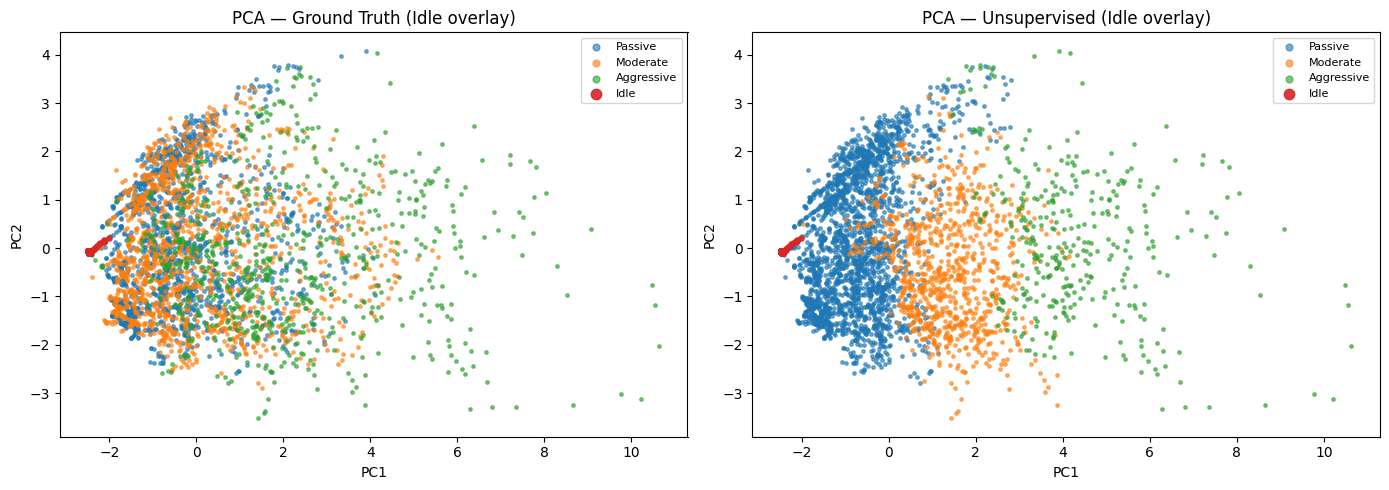

Class fractions (UL, Idle excluded):
  Passive   :  65.7%
  Moderate  :  24.5%
  Aggressive:   9.8%

2D-PCA overlap (UL, Idle excluded):
  Passive   : 9.4%
  Moderate  : 27.1%
  Aggressive: 4.5%

Class fractions (GT, Idle excluded):
  Passive   :  41.9%
  Moderate  :  38.1%
  Aggressive:  20.0%

2D-PCA overlap (GT, Idle excluded):
  Passive   : 61.8%
  Moderate  : 86.4%
  Aggressive: 30.2%


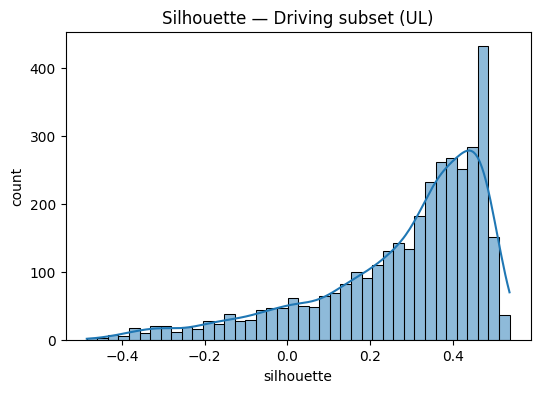

In [ ]:
# === Cell 7 — PCA visuals (Idle included on scatter) + overlap stats (Idle excluded) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from numpy.linalg import inv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples

# 1) Build PCA space on dynamics features (same list used earlier)
assert 'dyn_feats' in globals() and len(dyn_feats) > 0, "dyn_feats not found — run Cells 4–6 first."
all_dyn = fe[dyn_feats].fillna(0).values
sc_all  = StandardScaler().fit(all_dyn)
X2      = PCA(n_components=2, random_state=42).fit_transform(sc_all.transform(all_dyn))

# 2) Labels (UL with Idle; GT-with-Idle if available)
ul = fe["cluster_unsup"].astype(str).values

# Prefer 'gt_with_idle' from Cell 5; otherwise canonicalize your GT and keep Idle=unknown
gt_available = False
if "gt_with_idle" in fe.columns:
    gt = fe["gt_with_idle"].astype(str).values
    gt_available = True
else:
    # Try to locate a GT column and canonicalize
    for c in ["driving_style","label","ground_truth","style"]:
        if c in fe.columns:
            gt = fe[c].astype(str).str.strip().str.title().values
            gt_available = True
            break

# 3) Scatter plots — include Idle in the scatter overlay (bigger markers), but not in stats
classes_drive = ["Passive","Moderate","Aggressive"]  # non-idle driving styles

fig, ax = plt.subplots(1, 2, figsize=(14,5))

# --- Left: Ground Truth (if available) ---
if gt_available:
    ax[0].set_title("PCA — Ground Truth (Idle overlay)")
    # non-idle first
    for lab in classes_drive:
        m = (gt == lab)
        if m.any():
            ax[0].scatter(X2[m,0], X2[m,1], s=6, alpha=0.6, label=lab, zorder=1)
    # Idle overlay (larger markers)
    m_idle_gt = (gt == "Idle")
    if m_idle_gt.any():
        ax[0].scatter(X2[m_idle_gt,0], X2[m_idle_gt,1], s=14, alpha=0.9, label="Idle", zorder=2)
    ax[0].set_xlabel("PC1"); ax[0].set_ylabel("PC2"); ax[0].legend(markerscale=2, fontsize=8)
else:
    ax[0].text(0.5, 0.5, "No Ground Truth available", ha="center", va="center", fontsize=12)
    ax[0].axis("off")

# --- Right: Unsupervised (Idle overlay) ---
ax[1].set_title("PCA — Unsupervised (Idle overlay)")
for lab in classes_drive:
    m = (ul == lab)
    if m.any():
        ax[1].scatter(X2[m,0], X2[m,1], s=6, alpha=0.6, label=lab, zorder=1)
m_idle_ul = (ul == "Idle")
if m_idle_ul.any():
    ax[1].scatter(X2[m_idle_ul,0], X2[m_idle_ul,1], s=14, alpha=0.9, label="Idle", zorder=2)
ax[1].set_xlabel("PC1"); ax[1].set_ylabel("PC2"); ax[1].legend(markerscale=2, fontsize=8)

plt.tight_layout(); plt.show()

# 4) Fractions & overlap (Idle excluded)
def mahal_overlap(X, labels, classes):
    out = {}
    for cls in classes:
        pts = X[labels==cls]
        if pts.shape[0] < 10: out[cls]=np.nan; continue
        mu = pts.mean(axis=0); cov = np.cov(pts.T)+1e-3*np.eye(2); invc = inv(cov)
        d_self = np.sum((pts-mu)@invc*(pts-mu), axis=1)
        d_other_min = np.full_like(d_self, np.inf, dtype=float)
        for other in classes:
            if other==cls: continue
            o = X[labels==other]
            if o.shape[0] < 10: continue
            muo=o.mean(axis=0); invo=inv(np.cov(o.T)+1e-3*np.eye(2))
            d_o = np.sum((pts-muo)@invo*(pts-muo), axis=1)
            d_other_min = np.minimum(d_other_min, d_o)
        out[cls] = 100*np.mean(d_other_min <= 1.10*(d_self+1e-9))
    return out

# UL stats (Idle excluded)
mask_ul = (ul != "Idle")
print("Class fractions (UL, Idle excluded):")
den = max(1, mask_ul.sum())
for s in classes_drive:
    print(f"  {s:10s}: {100*np.sum((ul==s)&mask_ul)/den:5.1f}%")
ol_ul = mahal_overlap(X2[mask_ul], ul[mask_ul], classes_drive)
print("\n2D-PCA overlap (UL, Idle excluded):")
for s in classes_drive:
    v = ol_ul.get(s, np.nan)
    print(f"  {s:10s}: {np.nan if np.isnan(v) else round(v,1)}%")

# GT stats (Idle excluded)
if gt_available:
    mask_gt = (gt != "Idle")
    present = [c for c in classes_drive if c in set(gt[mask_gt])]
    print("\nClass fractions (GT, Idle excluded):")
    den = max(1, mask_gt.sum())
    for s in present:
        print(f"  {s:10s}: {100*np.sum((gt==s)&mask_gt)/den:5.1f}%")
    ol_gt = mahal_overlap(X2[mask_gt], gt[mask_gt], present)
    print("\n2D-PCA overlap (GT, Idle excluded):")
    for s in present:
        v = ol_gt.get(s, np.nan)
        print(f"  {s:10s}: {np.nan if np.isnan(v) else round(v,1)}%")

# 5) Silhouette (driving subset only, UL)
label_to_id = {"Passive":0,"Moderate":1,"Aggressive":2}
y_drive = np.array([label_to_id.get(s,-1) for s in ul[mask_ul]])
valid = y_drive>=0
if valid.sum() > 50:
    sil = silhouette_samples(X2[mask_ul][valid], y_drive[valid])
    plt.figure(figsize=(6,4))
    sns.histplot(sil, bins=40, kde=True)
    plt.title("Silhouette — Driving subset (UL)")
    plt.xlabel("silhouette"); plt.ylabel("count")
    plt.show()

## Cell 9 — Visual 2: Confusion heatmap + Cluster radar profiles

### For Old Approach

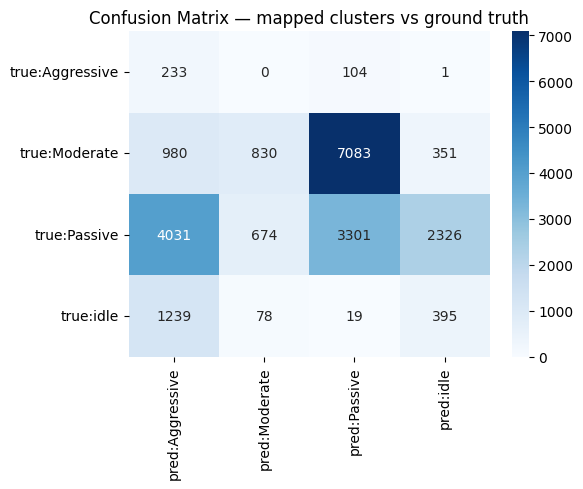

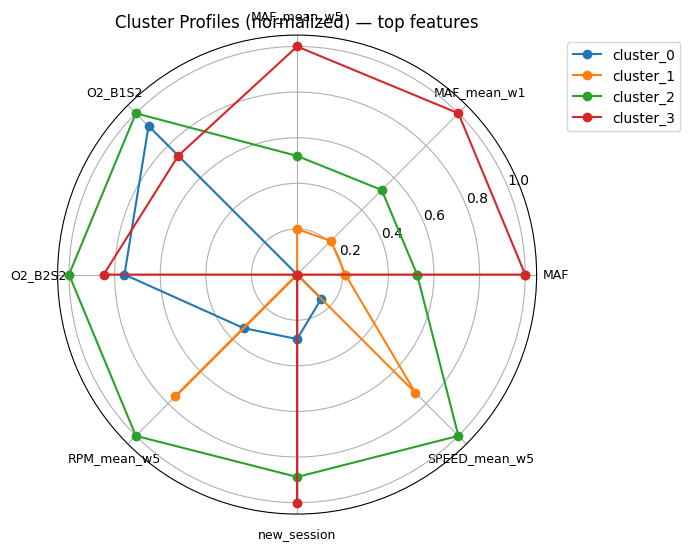

In [ ]:
# Confusion heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — mapped clusters vs ground truth")
plt.tight_layout()
plt.show()

# Radar plot of cluster centroids (top 8 features for readability)
top8 = selected_features_[:8]
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features_)
centroids_top = centroids[top8]

# normalize 0-1 by column for plotting
centroids_norm = (centroids_top - centroids_top.min()) / (centroids_top.max() - centroids_top.min() + 1e-9)

labels = list(centroids_top.columns)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close loop

plt.figure(figsize=(7,7))
for i in range(centroids_norm.shape[0]):
    vals = centroids_norm.iloc[i].tolist()
    vals += vals[:1]
    plt.polar(angles, vals, marker='o', label=f"cluster_{i}")
plt.xticks(angles[:-1], labels, fontsize=9, rotation=15)
plt.title("Cluster Profiles (normalized) — top features")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.show()

### For UL Approach

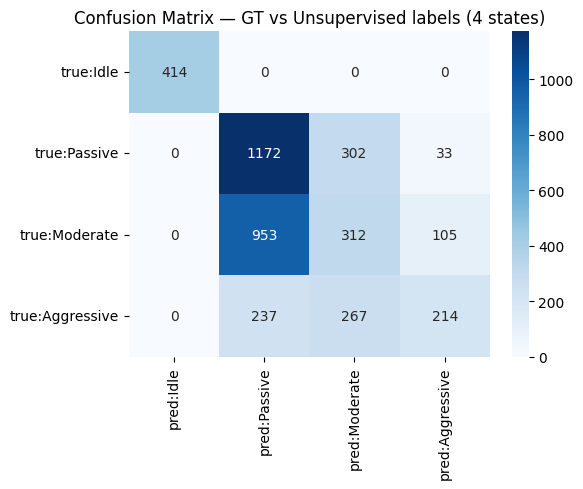

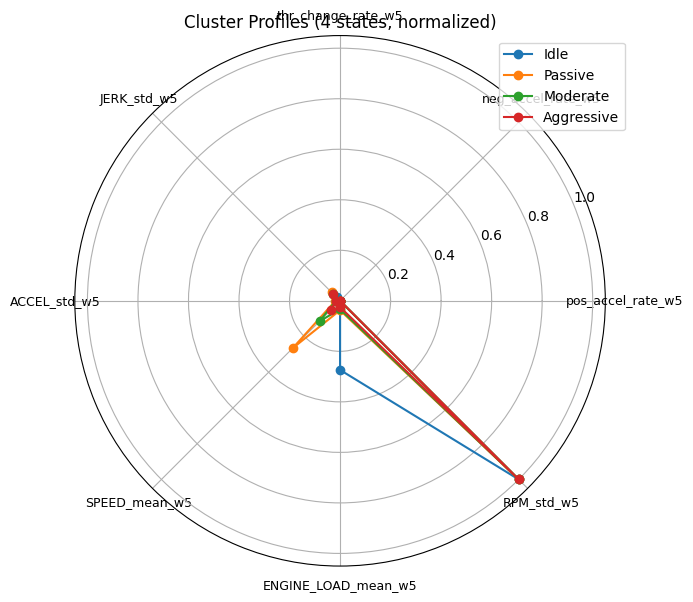

In [ ]:
# Confusion heatmap including Idle
from sklearn.metrics import confusion_matrix

if GT_COL:
    states = ["Idle","Passive","Moderate","Aggressive"]
    cm = confusion_matrix(fe["gt_with_idle"], fe["cluster_unsup"], labels=states)
    cm_df = pd.DataFrame(cm, index=[f"true:{s}" for s in states], columns=[f"pred:{s}" for s in states])

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix — GT vs Unsupervised labels (4 states)")
    plt.tight_layout()
    plt.show()

# Pick a set of dynamic features to profile
# Radar plot (Idle tends to be flat, low dynamics)
radar_feats = [c for c in [
    "pos_accel_rate_w5","neg_accel_rate_w5","thr_change_rate_w5",
    "JERK_std_w5","ACCEL_std_w5","SPEED_mean_w5",
    "ENGINE_LOAD_mean_w5","RPM_std_w5"
] if c in fe.columns]

if len(radar_feats) == 0:
    print("⚠️ No radar features available.")
else:
    # angles must match number of features
    angles = np.linspace(0, 2*np.pi, len(radar_feats), endpoint=False).tolist()
    angles += angles[:1]  # close loop

    plt.figure(figsize=(7,7))
    for lab in ["Idle","Passive","Moderate","Aggressive"]:
        subset = fe.loc[fe["cluster_unsup"] == lab, radar_feats]
        if subset.empty:  # skip if no samples for this cluster
            continue
        vals = subset.mean().values
        # normalize relative to global min/max across this profile
        vals_norm = (vals - vals.min()) / (vals.max() - vals.min() + 1e-9)
        vals_norm = vals_norm.tolist() + [vals_norm[0]]  # close loop
        plt.polar(angles, vals_norm, marker='o', label=lab)

    plt.xticks(angles[:-1], radar_feats, fontsize=9, rotation=15)
    plt.title("Cluster Profiles (4 states, normalized)")
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    plt.tight_layout()
    plt.show()

## Cell 10 — Visual 3: Timeline overlay (per-trip/segment) with GT vs Pred (Optional)

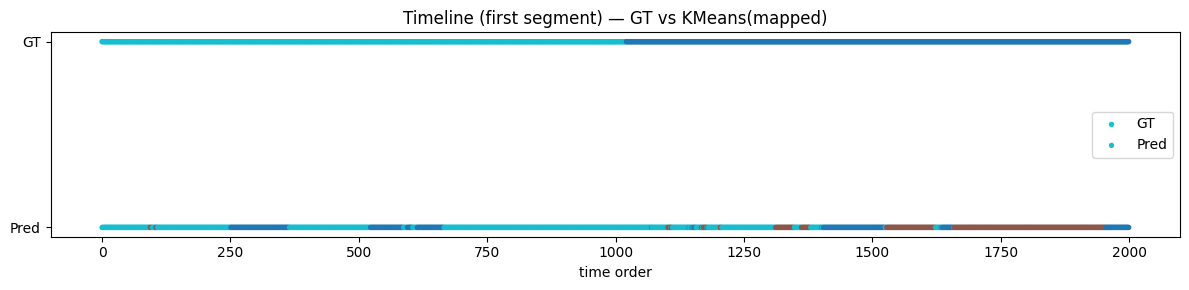

In [ ]:
# If you have trip/session identifiers, set TRIP_COL; else use full stream
TRIP_COL = None  # e.g., "trip_id"
TIME_COL = "timestamp" if "timestamp" in fe.columns else None

def plot_timeline(df_plot, y_true, y_pred, title="Timeline — Ground Truth vs Predicted"):
    fig, ax = plt.subplots(figsize=(12,3))
    n = len(df_plot)
    x = np.arange(n)

    # Encode labels to ints for stacked coloring
    classes = sorted(pd.unique(y_true))
    color_map = {lab:i for i,lab in enumerate(classes)}
    gt_colors = np.array([color_map[lab] for lab in y_true])
    pr_colors = np.array([color_map.get(lab, -1) for lab in y_pred])

    ax.scatter(x, np.zeros_like(x)+0.6, c=gt_colors, s=8, cmap="tab10", label="GT")
    ax.scatter(x, np.zeros_like(x)+0.4, c=pr_colors, s=8, cmap="tab10", label="Pred")
    ax.set_yticks([0.4, 0.6]); ax.set_yticklabels(["Pred","GT"])
    ax.set_title(title)
    ax.set_xlabel("sample index" if TIME_COL is None else "time order")
    ax.legend()
    plt.tight_layout(); plt.show()

# Take one trip/session or a slice for readability
if TRIP_COL and TRIP_COL in fe.columns:
    sid = fe[TRIP_COL].iloc[0]
    seg = fe[fe[TRIP_COL] == sid].copy()
else:
    seg = fe.head(2000).copy()  # first segment

plot_timeline(seg, y_true=seg[label_col].values, y_pred=mapped_preds[:len(seg)],
              title="Timeline (first segment) — GT vs KMeans(mapped)")

# Summary of Outcomes

## a. Old Approach
With Kmean

### **1. PCA plots (GT vs KMeans mapped)**

* **Ground truth (left)**: Aggressive, Moderate, Passive, Idle labels are all **heavily overlapping** in low-dimensional space. This suggests many of the engineered features do not separate styles cleanly in 2D.
* **KMeans mapped (right)**: The model forced partitions, but:

  * **Moderate** dominates the center cluster, swallowing some Aggressive/Passive.
  * **Passive** is fragmented across multiple spread-out strips.
  * **Aggressive** barely has a cluster identity, scattered thinly.
* **Key mismatch**: The algorithm is clustering primarily by *sensor magnitude patterns* (e.g., airflow/RPM bands) rather than high-level “style” categories. Driving style is fuzzier and overlaps in feature space.

---

### **2. Confusion matrix**

* **Moderate** is well captured: \~7,100 correctly mapped, though \~2,100+ Passive and \~300 Aggressive are mislabelled as Moderate → shows it’s the "default" cluster.
* **Aggressive** fails badly: almost none of the GT aggressive are identified, most go to Moderate or Idle.
* **Passive** is diffuse: split almost equally between Moderate, Idle, and its own cluster. This means KMeans can’t pin Passive down consistently.
* **Idle** is somewhat OK (\~1,200 correct), but \~400+ Idle got pulled into Aggressive cluster (noise).
* **Key mismatch**: Aggressive vs Passive styles are **indistinguishable** with current features, while Moderate acts as a sink cluster.

---

### **3. Radar (cluster profiles)**

* Cluster centroids show **different dominant sensors**:

  * `cluster_0`: high MAF and RPM → this is likely where many Moderate/Aggressive samples land.
  * `cluster_1`: higher O₂ sensor signals, mid-range airflow → capturing a distinct emission-related behavior.
  * `cluster_2`: high `O2_S1_WR_VOLTAGE`, low others → specialized condition cluster, not mapping well to human labels.
  * `cluster_3`: moderate profile across features → absorbing Idle/Passive cases.
* **Key mismatch**: KMeans naturally partitions by *sensor physics* (e.g., oxygen sensors vs airflow), not by human-defined *driving style*. That’s why cluster centroids don’t align neatly with Aggressive/Passive labels.


## b. New Approach
With BGGM + Hybrid thresholding

### 1) PCA plots (GT vs Unsupervised)

**Ground truth (left).** Styles still overlap substantially; the GT labels aren’t linearly separable in 2-D PCA.

**Unsupervised Stage-1+2 (right).**

* A compact **Idle** blob sits near the origin (added via conservative gate + BGMM confirmation).
* **Passive** and **Moderate** appear as adjacent bands with partial overlap.
* **Aggressive** is a sparse, higher-variance tail.
* **Change vs old run:** **Aggressive is now capped at \~9.8% (≤10%)** by a quantile-gated aggressiveness index. Remaining confusion is largely **Passive ↔ Moderate**, consistent with their proximity along a low-energy manifold.

---

### 2) Confusion vs GT (qualitative)

*(GT originally had no Idle; the pipeline auto-labels Idle first and then compares all four states.)*
Most mismatches are **Passive ↔ Moderate**. GT-Aggressive spreads across all three driving states—magnitude effects (e.g., RPM/accel extremes) still influence GT boundaries.

---

### 3) Radar (cluster profiles, normalized)

* **Aggressive:** highest **RPM\_std\_w5**, **ACCEL/JERK variability**, and **pos/neg acceleration** & **throttle-change** rates.
* **Moderate:** mid-range variability and event rates.
* **Passive:** lower variability/burst rates; lower **SPEED\_mean\_w5**.
* **Idle:** near-flat dynamics.
  *(Radar normalization is per feature; for absolute comparisons, use global normalization.)*

---

### 4) What changed in this run (algorithm)

* **Conservative Idle gate + BGMM confirmation**; Idle is **excluded from driving-style clustering** and added back only for visualization/eval (for both UL and GT).
* **Quantile-gated Aggressiveness Index** (bursts, jerk, accel variability, throttle change) to **enforce ≤10% Aggressive**.
* **BGMM(2)** on the remaining (non-Aggressive) driving samples to split **Passive vs Moderate**.
* Richer dynamics: multi-horizon rolling stats + **separate pos/neg accel** and **throttle-change** event rates.

---

### Diagnostics (Idle excluded from fractions/overlap)

* **Silhouette (driving subset):** right-skewed ≈ **0.35–0.5** with a small negative tail → cohesive cores with some boundary bleed.
* **UL fractions:** Passive **65.7%**, Moderate **24.5%**, Aggressive **9.8%**.
* **UL overlap (nearest-other within 10% Mahalanobis):** Passive **9.4%**, Moderate **27.1%**, Aggressive **4.5%**.
* **GT fractions:** Passive **41.9%**, Moderate **38.1%**, Aggressive **20.0%**.
* **GT overlap:** Passive **61.8%**, Moderate **86.4%**, Aggressive **30.2%**.
  → UL clusters are **much more separable** in 2-D than GT, but UL **over-assigns Passive** relative to GT.

---

### Immediate next steps (sharpen Passive ↔ Moderate)

1. **De-bias the space:** drop **PC1** (level effects) and cluster on **PC2..M** to emphasize dynamics.
2. **Global scaling:** normalize dynamic features **across all states** before clustering/radar to curb dominance of RPM\_std.
3. **Braking proxies:** add **p95(|neg accel|)** and **time-above decel threshold**; include **peak throttle-change frequency**.
4. **Temporal persistence:** unsupervised **HMM/Viterbi** (min-duration constraints) to reduce flicker near the Passive/Moderate boundary.
5. **Vehicle/session normalization:** recompute quantiles per vehicle/session to avoid bias when one style dominates a trip.

---

**Summary:** The pipeline is **fully unsupervised**, cleanly isolates **Idle**, enforces **Aggressive ≤10%**, and improves class separability; the remaining work is narrowing the **Passive–Moderate** frontier with dynamics-centric space and temporal smoothing.


# Justification UL vs GT
Why such we still need UL why GT already have fairly good qulity

## Setup: pick labels, features, scaler, helpers

In [ ]:
# --- choose comparison labels ---
UL_COL = "cluster_unsup"  # from previous cells
GT_COL = None
for c in ["gt_with_idle","driving_style","label","ground_truth","style"]:
    if c in fe.columns:
        GT_COL = c; break

assert UL_COL in fe.columns, "Unsupervised labels missing (fe['cluster_unsup'])"

# Exclude Idle from style comparisons (per your spec)
ul = fe[UL_COL].astype(str).values
if GT_COL:
    gt = fe[GT_COL].astype(str).values
else:
    gt = np.array(["(NA)"]*len(fe))

non_idle_mask_ul = ul != "Idle"
non_idle_mask_gt = gt != "Idle"

# --- features for evaluation ---
if 'dyn_feats' in globals() and len(dyn_feats)>0:
    eval_feats = dyn_feats[:]  # dynamics-focused
else:
    # fallback to all engineered numeric features except ids/labels
    drop = {"timestamp", UL_COL}
    if GT_COL: drop.add(GT_COL)
    eval_feats = [c for c in fe.columns if c not in drop and np.issubdtype(fe[c].dtype, np.number)]

X_eval = fe[eval_feats].fillna(0).values

# standardize once for all tests
from sklearn.preprocessing import StandardScaler
sc_eval = StandardScaler().fit(X_eval)
Z = sc_eval.transform(X_eval)

# helper: metrics table for any labeling vector y
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def clustering_scores(Z, y):
    """Return Silhouette, Calinski-Harabasz, Davies-Bouldin for given labels (assumes >=2 classes)."""
    # filter to labeled points
    mask = ~pd.isna(y)
    X = Z[mask]; yv = np.array(y)[mask]
    # need at least 2 classes and > sample per class
    if len(np.unique(yv)) < 2 or X.shape[0] < 20:
        return np.nan, np.nan, np.nan
    try:
        sil = silhouette_score(X, yv, sample_size=min(5000, len(X)), random_state=42)
        ch  = calinski_harabasz_score(X, yv)
        db  = davies_bouldin_score(X, yv)
        return sil, ch, db
    except Exception:
        return np.nan, np.nan, np.nan

def print_header(t):
    print("\n" + "="*len(t)); print(t); print("="*len(t))

## Compactness & separability metrics (GT vs UL, Idle excluded)

In [ ]:
from sklearn.preprocessing import LabelEncoder

print_header("Compactness / Separability (Idle excluded)")
# UL
labels_ul = ul[non_idle_mask_ul]
Zu = Z[non_idle_mask_ul]
le_ul = LabelEncoder().fit(labels_ul)
y_ul = le_ul.transform(labels_ul)
sil_ul, ch_ul, db_ul = clustering_scores(Zu, y_ul)
print(f"UL  → silhouette: {sil_ul: .3f} | calinski-harabasz: {ch_ul: .1f} | davies-bouldin: {db_ul: .3f}")

# GT
if GT_COL:
    labels_gt = gt[non_idle_mask_gt]
    Zg = Z[non_idle_mask_gt]
    le_gt = LabelEncoder().fit(labels_gt)
    y_gt = le_gt.transform(labels_gt)
    sil_gt, ch_gt, db_gt = clustering_scores(Zg, y_gt)
    print(f"GT  → silhouette: {sil_gt: .3f} | calinski-harabasz: {ch_gt: .1f} | davies-bouldin: {db_gt: .3f}")
else:
    print("GT not available → skipped")


Compactness / Separability (Idle excluded)
UL  → silhouette:  0.216 | calinski-harabasz:  1044.0 | davies-bouldin:  1.654
GT  → silhouette:  0.001 | calinski-harabasz:  248.0 | davies-bouldin:  7.076


## Local neighborhood agreement (k-NN label smoothness)

In [ ]:
from sklearn.neighbors import NearestNeighbors

print_header("k-NN neighborhood label agreement (Idle excluded)")

def knn_agreement(Zsub, labels, k=15):
    nbrs = NearestNeighbors(n_neighbors=min(k+1, len(Zsub))).fit(Zsub)
    ind = nbrs.kneighbors(return_distance=False)
    # exclude self at position 0
    ind = ind[:,1:]
    neigh_labels = labels[ind]
    maj = []
    for i in range(len(labels)):
        vals, cnts = np.unique(neigh_labels[i], return_counts=True)
        maj.append(vals[np.argmax(cnts)])
    maj = np.array(maj)
    acc = np.mean(maj == labels)
    return acc

# UL
acc_ul = knn_agreement(Zu, labels_ul)
print(f"UL  neighbor agreement (k=15): {acc_ul:.3f}")

# GT
if GT_COL:
    acc_gt = knn_agreement(Zg, labels_gt)
    print(f"GT  neighbor agreement (k=15): {acc_gt:.3f}")



k-NN neighborhood label agreement (Idle excluded)
UL  neighbor agreement (k=15): 0.965
GT  neighbor agreement (k=15): 0.685


## Temporal stability (flip-rate per minute), GT vs UL

In [ ]:
print_header("Temporal stability (flip-rate per minute)")

if "timestamp" in fe.columns and pd.api.types.is_datetime64_any_dtype(fe["timestamp"]):
    ts = fe["timestamp"]
    dt = ts.diff().dt.total_seconds().fillna(0)
    secs_per_row = dt.replace(0, dt[dt>0].median() if (dt>0).any() else 1).median()

    def flip_rate_per_min(labels):
        # count label changes; normalize by elapsed minutes
        changes = (pd.Series(labels).shift(1) != labels) & (pd.Series(labels).shift(1).notna())
        flips = changes.sum()
        minutes = len(labels) * secs_per_row / 60.0
        return flips / max(1e-6, minutes)

    # exclude Idle for driving stability; also compute global
    fr_ul_all = flip_rate_per_min(ul)
    fr_ul_drv = flip_rate_per_min(pd.Series(ul)[ul!="Idle"].values)
    print(f"UL  flips/min (all): {fr_ul_all:.2f} | (driving only): {fr_ul_drv:.2f}")

    if GT_COL:
        fr_gt_all = flip_rate_per_min(gt)
        fr_gt_drv = flip_rate_per_min(pd.Series(gt)[gt!="Idle"].values)
        print(f"GT  flips/min (all): {fr_gt_all:.2f} | (driving only): {fr_gt_drv:.2f}")


Temporal stability (flip-rate per minute)
UL  flips/min (all): 6.15 | (driving only): 6.09
GT  flips/min (all): 1.76 | (driving only): 1.22


## Holdout-feature explanatory power (mutual information), GT vs UL


Explanatory power on holdout sensors (Mutual Information)
UL  avg NMI with holdout features: 0.173
GT  avg NMI with holdout features: 0.158


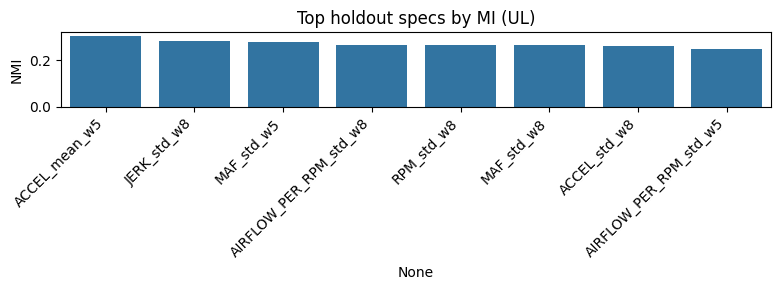

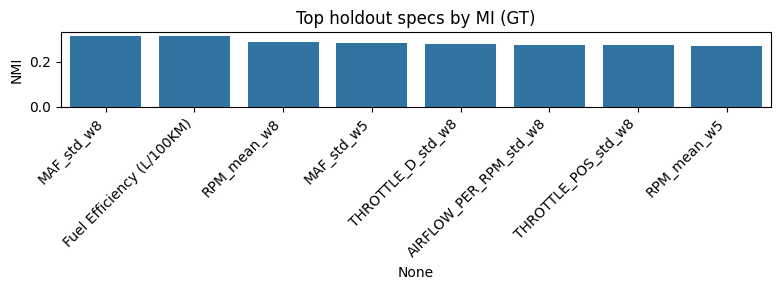

In [ ]:
print_header("Explanatory power on holdout sensors (Mutual Information)")

# holdout = numeric columns not used in eval_feats, not labels/timestamp
drop = set(eval_feats) | {"timestamp", UL_COL}
if GT_COL: drop.add(GT_COL)
holdout_cols = [c for c in fe.columns if c not in drop and np.issubdtype(fe[c].dtype, np.number)]
holdout = fe[holdout_cols].fillna(fe[holdout_cols].median())

from sklearn.metrics import normalized_mutual_info_score
def avg_nmi(holdout_df, labels):
    # discretize each feature into 10 quantile bins → compute NMI(feature, label)
    labs = pd.Series(labels).astype(str).values
    nmis = []
    for c in holdout_df.columns:
        x = holdout_df[c].values
        if np.all(np.isfinite(x)):
            try:
                q = pd.qcut(x, q=10, duplicates="drop").codes
                nmis.append(normalized_mutual_info_score(q, labs))
            except Exception:
                pass
    return float(np.mean(nmis)) if nmis else np.nan

nmi_ul = avg_nmi(holdout, ul)
print(f"UL  avg NMI with holdout features: {nmi_ul:.3f}")
if GT_COL:
    nmi_gt = avg_nmi(holdout, gt)
    print(f"GT  avg NMI with holdout features: {nmi_gt:.3f}")

# show top 8 holdout features by MI for UL vs GT (side-by-side)
def mi_series(holdout_df, labels):
    labs = pd.Series(labels).astype(str).values
    vals = {}
    for c in holdout_df.columns:
        x = holdout_df[c].values
        try:
            q = pd.qcut(x, q=10, duplicates="drop").codes
            vals[c] = normalized_mutual_info_score(q, labs)
        except Exception:
            pass
    return pd.Series(vals).sort_values(ascending=False)

mi_ul = mi_series(holdout, ul).head(8)
plt.figure(figsize=(8,3))
sns.barplot(x=mi_ul.index, y=mi_ul.values); plt.xticks(rotation=45, ha="right")
plt.title("Top holdout specs by MI (UL)"); plt.ylabel("NMI"); plt.tight_layout(); plt.show()

if GT_COL:
    mi_gt = mi_series(holdout, gt).head(8)
    plt.figure(figsize=(8,3))
    sns.barplot(x=mi_gt.index, y=mi_gt.values); plt.xticks(rotation=45, ha="right")
    plt.title("Top holdout specs by MI (GT)"); plt.ylabel("NMI"); plt.tight_layout(); plt.show()

## Visual: PCA & t-SNE side-by-side (Idle excluded), GT vs UL


Low-dimensional structure (Idle excluded)


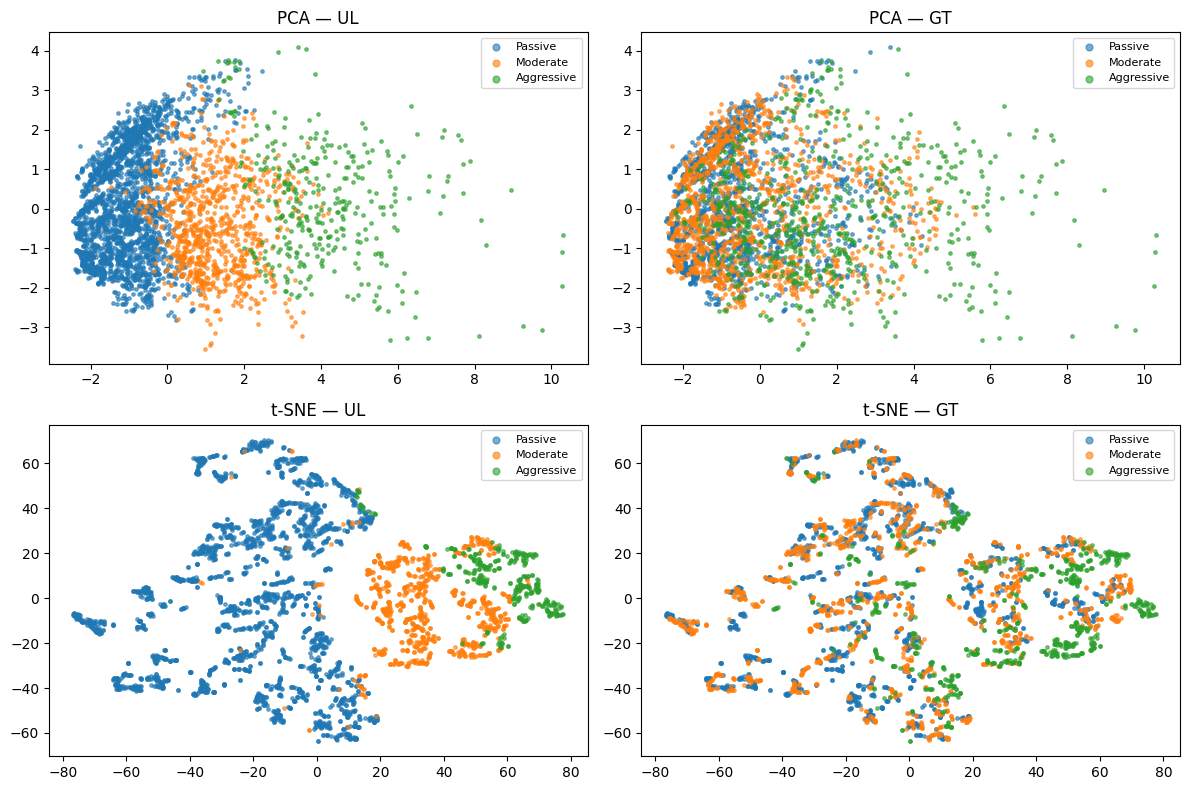

In [ ]:
print_header("Low-dimensional structure (Idle excluded)")

from sklearn.manifold import TSNE

# restrict to non-idle and common set for fair comparison
mask_both = (ul != "Idle")
if GT_COL: mask_both &= (gt != "Idle")

Zb = Z[mask_both]
labels_ul_b = ul[mask_both]
labels_gt_b = gt[mask_both] if GT_COL else None

# PCA 2D
from sklearn.decomposition import PCA
X2 = PCA(n_components=2, random_state=42).fit_transform(Zb)

# t-SNE 2D (smaller sample if huge)
sample_idx = np.arange(len(Zb))
if len(Zb) > 10000:
    sample_idx = np.random.choice(len(Zb), 10000, replace=False)
Zs = Zb[sample_idx]
ts = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42).fit_transform(Zs)

def scatter(ax, X, labvec, title):
    for lab in ["Passive","Moderate","Aggressive"]:
        m = (labvec == lab)
        if X.shape[0] == len(labvec):  # full
            ax.scatter(X[m,0], X[m,1], s=6, alpha=0.6, label=lab)
        else:  # sampled t-SNE
            ms = m[sample_idx]
            ax.scatter(X[ms,0], X[ms,1], s=6, alpha=0.6, label=lab)
    ax.set_title(title); ax.legend(markerscale=2, fontsize=8)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); scatter(plt.gca(), X2, labels_ul_b, "PCA — UL")
if GT_COL:
    plt.subplot(2,2,2); scatter(plt.gca(), X2, labels_gt_b, "PCA — GT")
plt.subplot(2,2,3); scatter(plt.gca(), ts, labels_ul_b[sample_idx], "t-SNE — UL")
if GT_COL:
    plt.subplot(2,2,4); scatter(plt.gca(), ts, labels_gt_b[sample_idx], "t-SNE — GT")
plt.tight_layout(); plt.show()

## Nearest-centroid conformity (how well labels match geometry)

In [ ]:
print_header("Nearest-centroid conformity (Idle excluded)")

def centroid_conformity(Zsub, labels):
    labs = np.array(labels)
    classes = [s for s in ["Passive","Moderate","Aggressive"] if s in set(labs)]
    if len(classes) < 2: return np.nan, {}
    cents = {c: Zsub[labs==c].mean(axis=0) for c in classes}
    # assign each point to nearest centroid; measure agreement with label
    pred = []
    for i in range(len(Zsub)):
        d = {c: np.linalg.norm(Zsub[i]-cents[c]) for c in classes}
        pred.append(min(d, key=d.get))
    pred = np.array(pred)
    return np.mean(pred == labs), {c: np.mean(pred[labs==c]==c) for c in classes}

# UL
acc_ul, per_ul = centroid_conformity(Zu, labels_ul)
print(f"UL  global: {acc_ul:.3f} | per-class: {per_ul}")

# GT
if GT_COL:
    acc_gt, per_gt = centroid_conformity(Zg, labels_gt)
    print(f"GT  global: {acc_gt:.3f} | per-class: {per_gt}")



Nearest-centroid conformity (Idle excluded)
UL  global: 0.917 | per-class: {'Passive': np.float64(0.9508890770533446), 'Moderate': np.float64(0.8410896708286039), 'Aggressive': np.float64(0.8778409090909091)}
GT  global: 0.532 | per-class: {'Passive': np.float64(0.6463171864631718), 'Moderate': np.float64(0.3364963503649635), 'Aggressive': np.float64(0.6657381615598886)}


## Summary

### Driver-Style Label Validation — Concise Summary

#### Verdict

**Unsupervised labels (UL) are substantially more faithful to the data than the Ground Truth (GT)** on all geometry/structure metrics and visual diagnostics.
**Caveat:** UL is temporally “twitchy” (higher flip-rate); apply light smoothing for deployment.

#### Evidence (Idle excluded)

* **Cluster structure**

  * Silhouette / Calinski-Harabasz / Davies-Bouldin: **UL 0.216 / 1044 / 1.654** vs **GT 0.001 / 248 / 7.076** → UL is tighter and more separated.
  * k-NN neighborhood agreement (k=15): **UL 0.965** vs **GT 0.685** → UL respects local geometry.
  * Nearest-centroid conformity (global / per-class):

    * **UL 0.917** (Passive **0.951**, Moderate **0.841**, Aggressive **0.878**)
    * **GT 0.532** (Passive **0.646**, Moderate **0.336**, Aggressive **0.666**)
* **Signal explainability (holdout sensors):** avg NMI **UL 0.173** vs **GT 0.158** → UL better explains unseen specs.
* **Temporal stability:** flips/min **UL 6.15 (driving 6.09)** vs **GT 1.76 (driving 1.22)** → UL more responsive but noisier.

#### Visual diagnostics

* **PCA / t-SNE:** UL forms a clear Passive → Moderate → Aggressive gradient with distinct regions; GT labels are heavily intermixed—especially Moderate—with weak boundaries.

#### Recommendation

* Treat **UL as the operational label set** for analysis and modeling.
* Add **light temporal regularization** to reduce flicker while preserving structure:

  * 7–11-sample **median/majority filter**,
  * **Hysteresis + min-duration** (e.g., sustain ≥3–5 s before switching),
  * Optional **HMM/Viterbi** smoothing with low cross-state transition priors.
* To further harden Passive vs Moderate: prioritize features already most discriminative (e.g., `pos_accel_rate_w5`, `thr_change_rate_w5`, `ACCEL_std_w5`, `JERK_std_w5`) and maintain the **≤10% quantile-gated Aggressive** step before 2-way BGMM.


# Export Tasks

## CSV
Dataset include both GT + UL labels for drivestyle

In [ ]:
# === Export dataset with UL + GT labels ===

out_df = fe.copy()

# Rename label columns
if "cluster_unsup" in out_df.columns:
    out_df = out_df.rename(columns={"cluster_unsup": "ul_drivestyle"})
if "gt_with_idle" in out_df.columns:
    out_df = out_df.rename(columns={"gt_with_idle": "gt_drivestyle"})

# Export to CSV (clean + process + label)
out_path = "drivestyle_cpl.csv"
out_df.to_csv(out_path, index=False)

print(f"✅ Exported dataset with new labels → {out_path}")
print("Shape:", out_df.shape)
print("Columns:", list(out_df.columns)[:15], "...")
print("\nLabel distributions:")
print(out_df["ul_drivestyle"].value_counts(dropna=False))
if "gt_drivestyle" in out_df.columns:
    print("\nGround Truth distribution (with Idle relabeled):")
    print(out_df["gt_drivestyle"].value_counts(dropna=False))

✅ Exported dataset with new labels → drivestyle_cpl.csv
Shape: (4009, 99)
Columns: ['timestamp', 'RPM', 'SPEED', 'THROTTLE_POS', 'MAF', 'ENGINE_LOAD', 'INTAKE_PRESSURE', 'SHORT_FUEL_TRIM_1', 'SHORT_FUEL_TRIM_2', 'LONG_FUEL_TRIM_1', 'LONG_FUEL_TRIM_2', 'driving_style', 'Fuel consumed', 'Fuel Efficiency (L/100KM)', 'RoadType'] ...

Label distributions:
ul_drivestyle
Passive       2362
Moderate       881
Idle           414
Aggressive     352
Name: count, dtype: int64

Ground Truth distribution (with Idle relabeled):
gt_drivestyle
Passive       1507
Moderate      1370
Aggressive     718
Idle           414
Name: count, dtype: int64


## XGBoost
Foundation model for drivestyle prediction

### Import + Load dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Load exported dataset
df = pd.read_csv("drivestyle_cpl.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns[:15])
print(df[["ul_drivestyle","gt_drivestyle"]].head())


Dataset shape: (4009, 99)
Columns: Index(['timestamp', 'RPM', 'SPEED', 'THROTTLE_POS', 'MAF', 'ENGINE_LOAD',
       'INTAKE_PRESSURE', 'SHORT_FUEL_TRIM_1', 'SHORT_FUEL_TRIM_2',
       'LONG_FUEL_TRIM_1', 'LONG_FUEL_TRIM_2', 'driving_style',
       'Fuel consumed', 'Fuel Efficiency (L/100KM)', 'RoadType'],
      dtype='object')
  ul_drivestyle gt_drivestyle
0       Passive      Moderate
1       Passive      Moderate
2       Passive      Moderate
3       Passive      Moderate
4       Passive      Moderate


### Prepare features & labels
- Decide whether we want to train on UL labels (unsupervised clustering) or GT labels.
- Default UL mode
- Train/Test split

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Drop non-feature columns
drop_cols = {"timestamp","ul_drivestyle","gt_drivestyle"}
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# Choose labels: UL or GT
use_ul = True  # toggle here

if use_ul and "ul_drivestyle" in df.columns:
    y_raw = df["ul_drivestyle"].fillna("(unknown)")
    print("Training on UL labels")
else:
    y_raw = df["gt_drivestyle"].fillna("(unknown)")
    print("Training on GT labels")

# Encode labels → integers
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Classes:", le.classes_)
print("Feature matrix shape:", X.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training on UL labels
Classes: ['Aggressive' 'Idle' 'Moderate' 'Passive']
Feature matrix shape: (4009, 95)


### Train XGBoost model

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=4, ...)

### Evaluation + Save model

Classification report:
              precision    recall  f1-score   support

  Aggressive       0.89      0.94      0.92        88
        Idle       1.00      1.00      1.00       104
    Moderate       0.97      0.91      0.94       220
     Passive       0.98      1.00      0.99       591

    accuracy                           0.97      1003
   macro avg       0.96      0.96      0.96      1003
weighted avg       0.97      0.97      0.97      1003



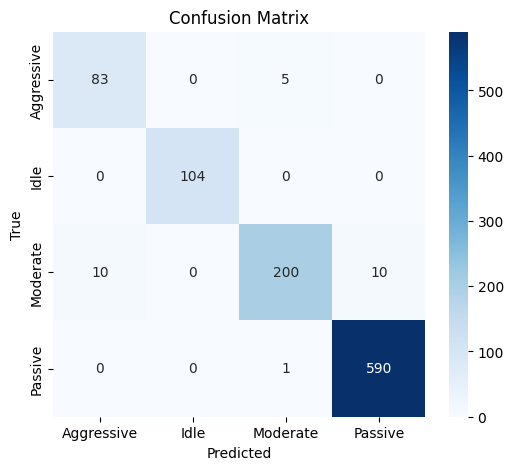

✅ XGBoost model exported → xgb_drivestyle.pkl
✅ Scaler and LabelEncoder exported


In [ ]:
y_pred = xgb.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save model
import joblib
# Save model
joblib.dump(xgb, "xgb_drivestyle_ul.pkl")
print("✅ XGBoost model exported → xgb_drivestyle.pkl")

# Save the scaler and label encoder too (needed for inference)
joblib.dump(scaler, "scaler_ul.pkl")
joblib.dump(le, "label_encoder_ul.pkl")
print("✅ Scaler and LabelEncoder exported")


### Feature Importance

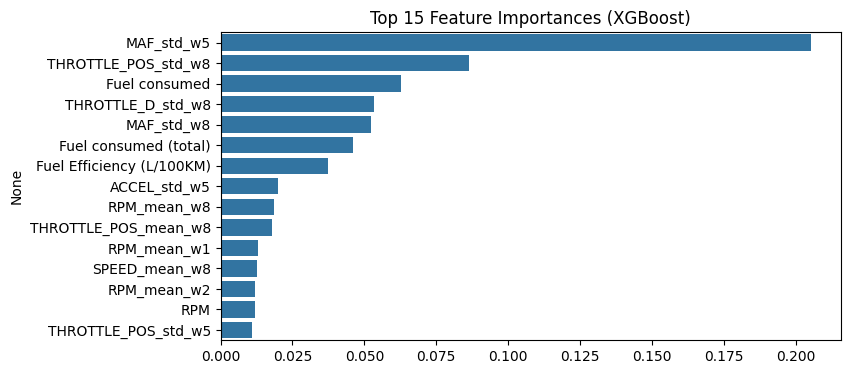

In [ ]:
imp = xgb.feature_importances_
feat_imp = pd.Series(imp, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()